## Implementing Neural Networks from Scratch from Andrej Karpathy's Youtube video 

Link to the video: https://www.youtube.com/watch?v=VMj-3S1tku0

We will use micrograd that Andrej has developed. It helps with backpropagation by building computation graphs to find derivatives when dealing with layered functions. 

In [257]:
#micrograd 
!pip3 install micrograd

In [63]:
!pip3 install graphviz

In [187]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

In [12]:
from micrograd.engine import Value
# trivial mathematical function: 
a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


Going deeper into micrograd:

In [15]:
xs = np.arange(-5,5,.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [16]:
#defining a function: 

def f(x):
    return 3*x**2 + 2*x - 7

In [18]:
ys = f(xs)
ys

array([58.    , 51.1875, 44.75  , 38.6875, 33.    , 27.6875, 22.75  ,
       18.1875, 14.    , 10.1875,  6.75  ,  3.6875,  1.    , -1.3125,
       -3.25  , -4.8125, -6.    , -6.8125, -7.25  , -7.3125, -7.    ,
       -6.3125, -5.25  , -3.8125, -2.    ,  0.1875,  2.75  ,  5.6875,
        9.    , 12.6875, 16.75  , 21.1875, 26.    , 31.1875, 36.75  ,
       42.6875, 49.    , 55.6875, 62.75  , 70.1875])

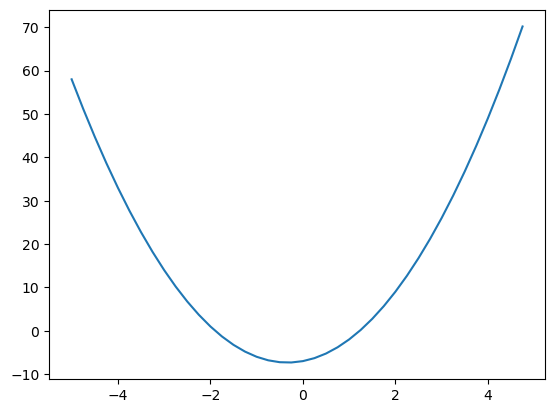

In [19]:
# let's plot it now 

plt.plot(xs,ys)

In [20]:
# how can we find derivatives at different values of x? 

# we can't derive the deriavtive since the equation of the neural network would be insanely massive 

In [23]:
x = 0
h = 0.001
f(x)

-7

In [24]:
f(x+h)

-6.997997

In [25]:
# now getting the slope: 
slope = (f(x+h) - f(x)) / h
slope

2.003000000000199

In [26]:
def get_slope(x):
    return (f(x+h) - f(x)) / h

In [27]:
get_slope(3)

20.003000000002658

In [28]:
get_slope(-1)

-3.9970000000000283

In [32]:
get_slope(-.34)

-0.03700000000073089

In [35]:
#getting more complicated 

h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [36]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [37]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [142]:
#lets build out micrograd now 

class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out 
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1) # directly used the formula for tan h 
        out = Value(t, (self,), 'tanh')
        return out 

        

In [127]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value(data=-8.0)

In [89]:
# code to visualize the computation graph: 
# note that code was taken from Andrej

from graphviz import Digraph

def trace(root):
   # builds a set of all nodes and edges in a graph
   nodes, edges = set(), set()
   def build(v):
       if v not in nodes:
           nodes.add(v)
           for child in v._prev:
               edges.add((child, v))
               build(child)
   build(root)
   return nodes, edges

def draw_dot(root):
   dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
   
   nodes, edges = trace(root)
   for n in nodes:
       uid = str(id(n))
       # for any value in the graph, create a rectangular ('record') node for it
       dot.node(name = uid, label = "{ %s | data %.4f  | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
       #dot.node(name = uid, label = "{ data %.4f }" % (n.data, ), shape='record')
       if n._op:
           # if this value is a result of some operation, create an op node for it
           dot.node(name = uid + n._op, label = n._op)
           # and connect this node to it
           dot.edge(uid + n._op, uid)
   
   for n1, n2 in edges:
       # connect n1 to the op node of n2
       dot.edge(str(id(n1)), str(id(n2)) + n2._op)
   
   return dot

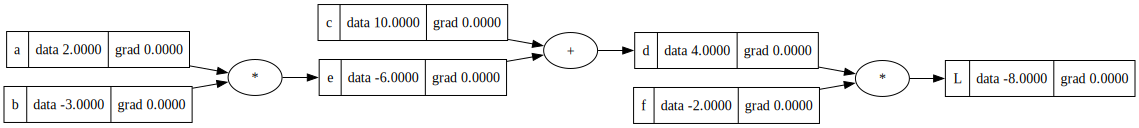

In [90]:
draw_dot(L)

In [92]:
L.grad

0.0

Let's go through a manual backpropagation for one example 

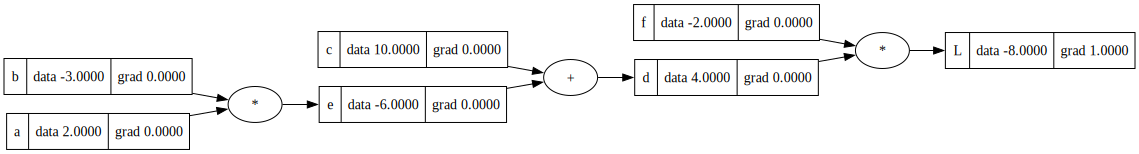

In [128]:
L.grad = 1
draw_dot(L)

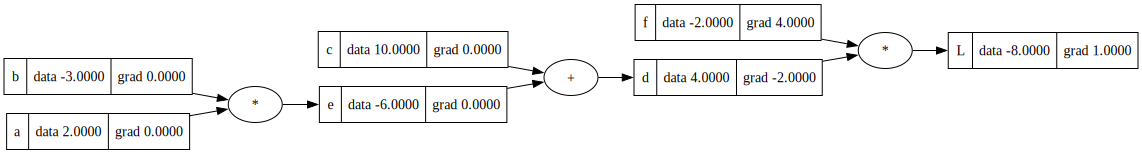

In [129]:
# dL/dd --> f --> -2
d.grad = -2
f.grad = 4
draw_dot(L)

Now how do we get dL/dc? 

DL/dc = dL/dd * dd/dc --> -2 * 1 = -2

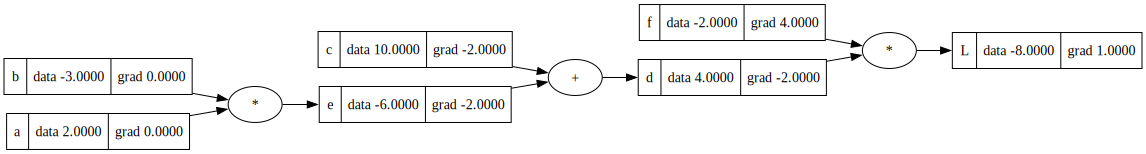

In [130]:
c.grad = -2
e.grad = -2
draw_dot(L)

dL/da = ? 
dL/da = de/da * dL/de --? b * -2 = -2b

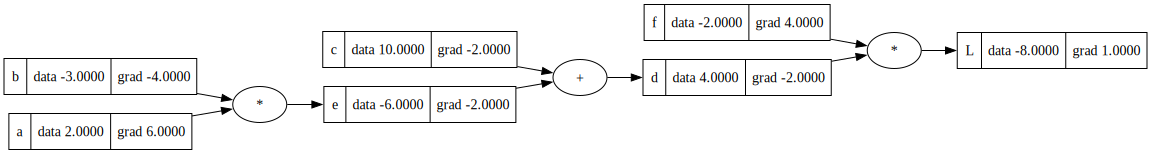

In [131]:
a.grad = -2 * -3
b.grad = -2 * 2
draw_dot(L)

In [132]:
# one step of the optimization: (you should get a value closer to 0 from -8)

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [134]:
# showing another step of optimization:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-6.586368000000001


In [99]:
# checker code for derivatives wrapped in a function to not change global variables 
def lol():
    
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0+h, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0  , label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print((L2 - L1)/h)

lol()

0.0


Let's now backpropogate through a neuron where we have a number of inputs (x's) with corresponding weights that are multiplied and added together along with a bias. It's then outputted with an activation function


output = activation(summation(w*x + b))

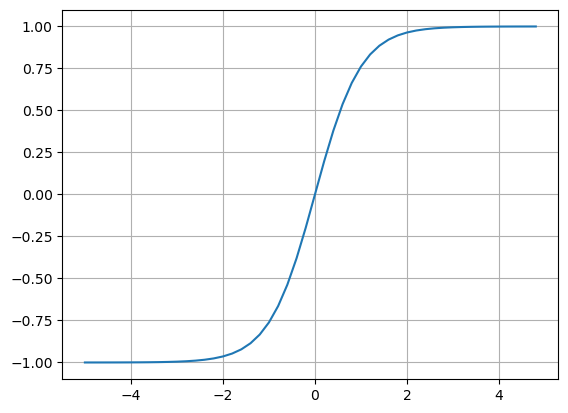

In [138]:
# take a look at the activation function: 
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,.2)))
plt.grid()

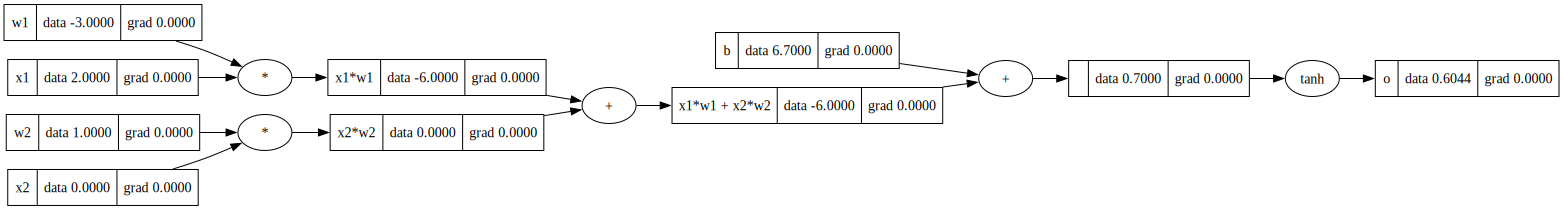

In [146]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.7, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b 

o = n.tanh() ; o.label = 'o'

n = x1w1x2w2 + b; n.label = 'n'

draw_dot(o)

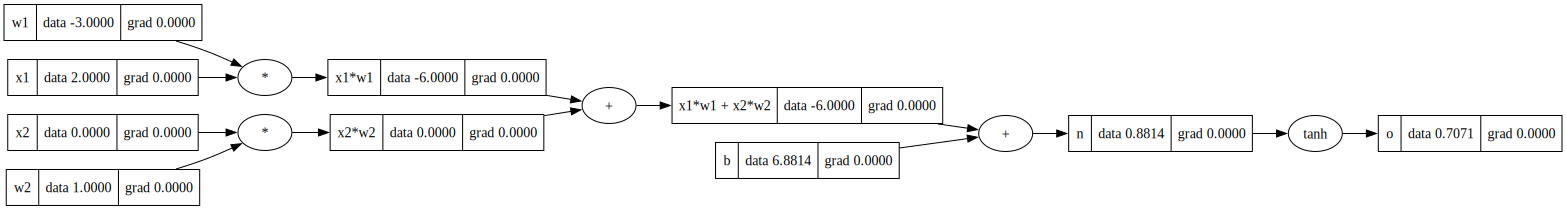

In [157]:
# changing the values a bit for a nice example:
# remember that we want to optimize the weights (the parameter we have control over)

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

Let;s start the backpropagation:

o = tanh(x) --> 
do/dx = 1 - o**2

In [158]:
o.grad = 1

In [159]:
ngrad = 1 - o.data **2
ngrad

0.4999999999999999

In [160]:
n.grad = .5


now we have a plus (addition operations just carry the gradient through so the gradient should be the same but multiplied by a constant/linear)

In [161]:
b.grad = .5
x1w1x2w2.grad = .5

we encounter another addition operation so the gradient will flow backwards 'as is' 

let's draw out what we have so far

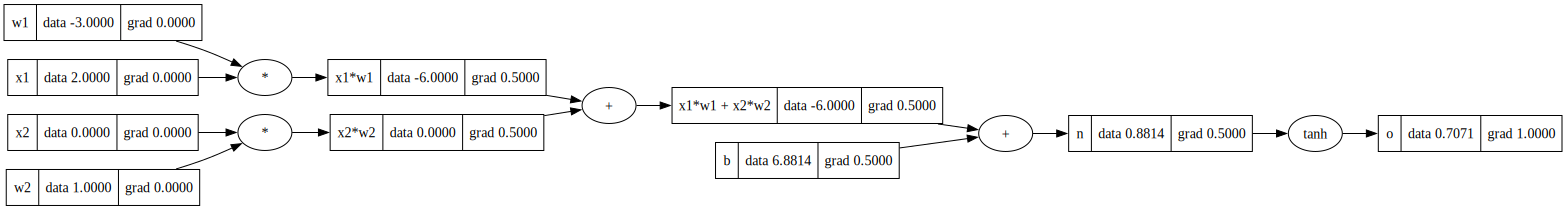

In [162]:
x1w1.grad = 0.5
x2w2.grad = 0.5

draw_dot(o)

now we face multiplication 

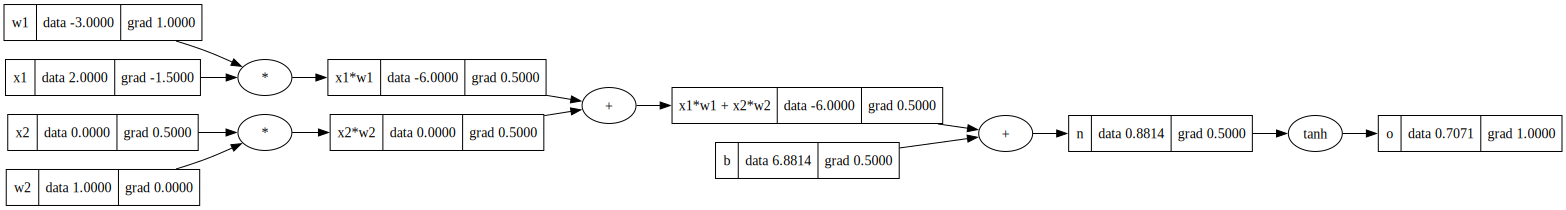

In [163]:
#dL/dw1 = ? --> dL/x1w1 * dx1w1/dw1 = x1
#dL/dw2 = x2

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

draw_dot(o)

Now that we have an idea of how backpropagation works, let's implement it in the class Value:

In [164]:
# implementing _backward 
class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out =  Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad = out.grad * 1 # since additions just propogate the gradients through the network 
            other.grad = out.grad * 1 
        
        out._backward = _backward

        return out

    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data

        out._backward = _backward

        return out 
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1) # directly used the formula for tan h 
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out 

Note that we need to initialize o grad as 1 as the base case 

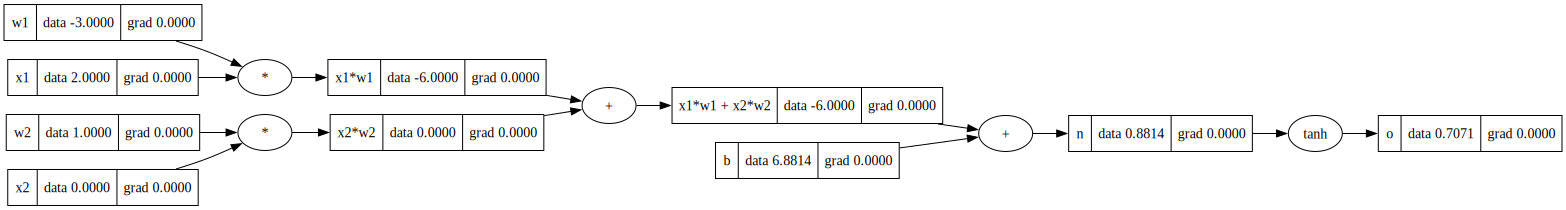

In [168]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

In [169]:
o.grad = 1
o._backward()

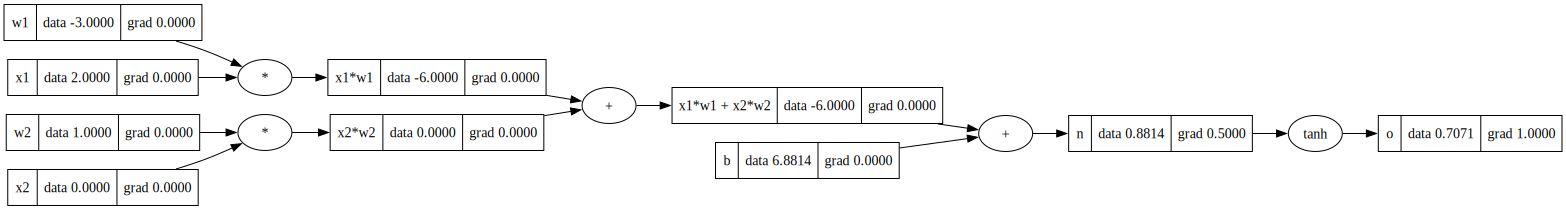

In [170]:
draw_dot(o)

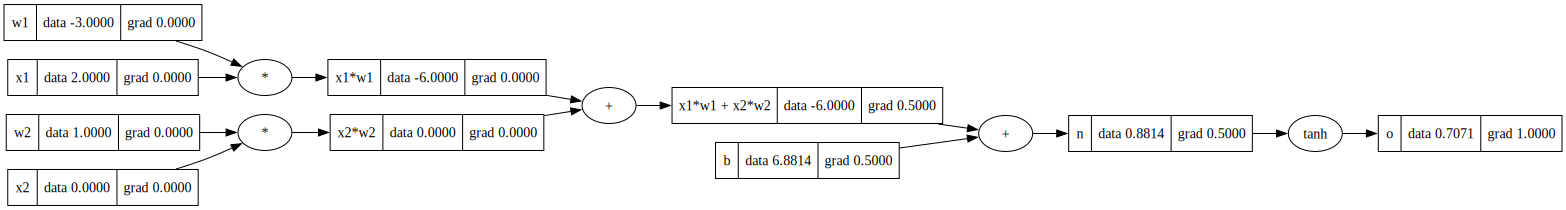

In [171]:
n._backward()
draw_dot(o)

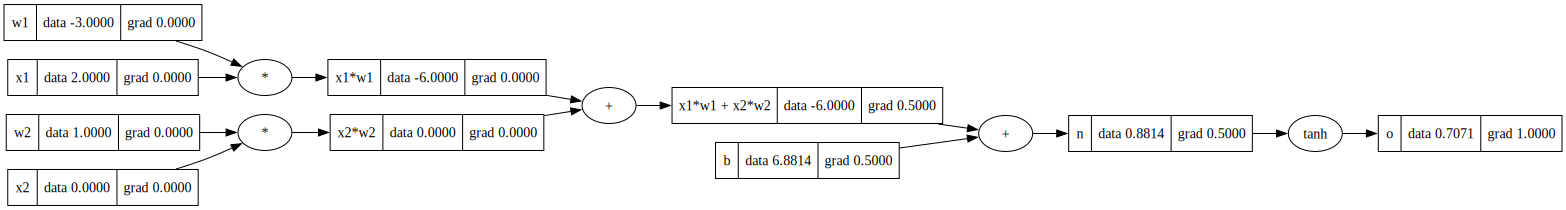

In [172]:
b._backward()
draw_dot(o)

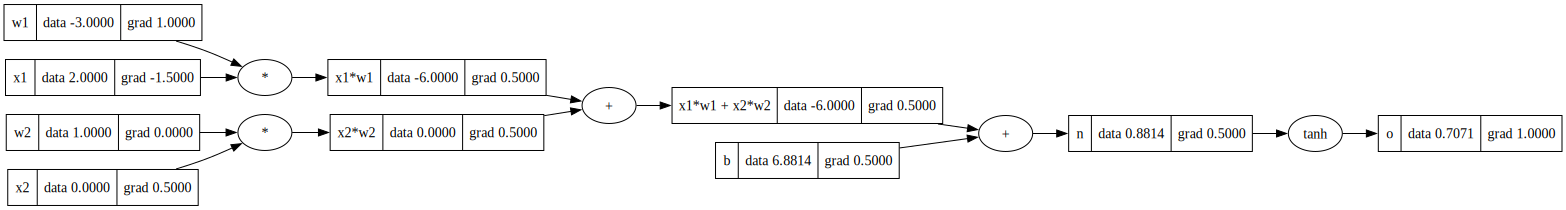

In [173]:
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
draw_dot(o)

Now we want to NOT call the backward function many times:

This can be achieved with a topological sort 

In [174]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

remember to set the initial gradient of o to 1 otherwise everything will be 0 

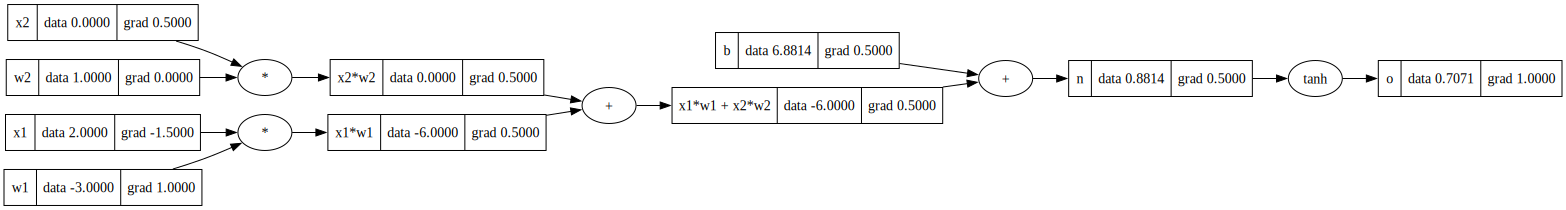

In [176]:
# implement it with the gradients reset: 
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
o.grad = 1
for node in reversed(topo):
    node._backward()

draw_dot(o)


We can clean up this functionality by making it part of the Value class 

In [180]:
# implementing _backward 
class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        out =  Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad = out.grad * 1 # since additions just propogate the gradients through the network 
            other.grad = out.grad * 1 
        
        out._backward = _backward

        return out

    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data

        out._backward = _backward

        return out 
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1) # directly used the formula for tan h 
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out 
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
        

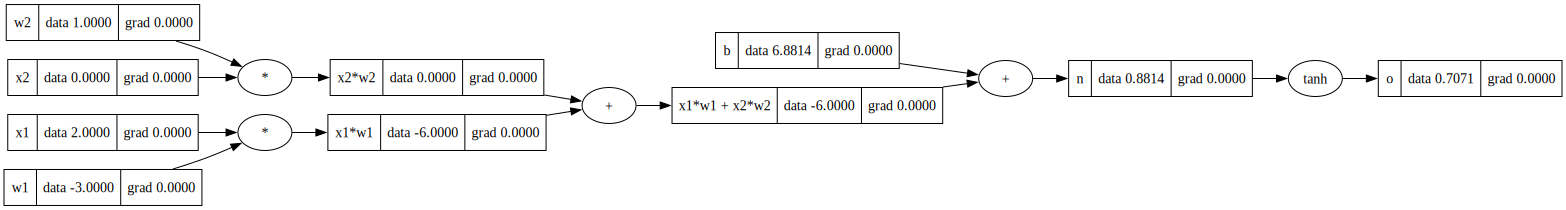

In [181]:
# redefine NN equation:

x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

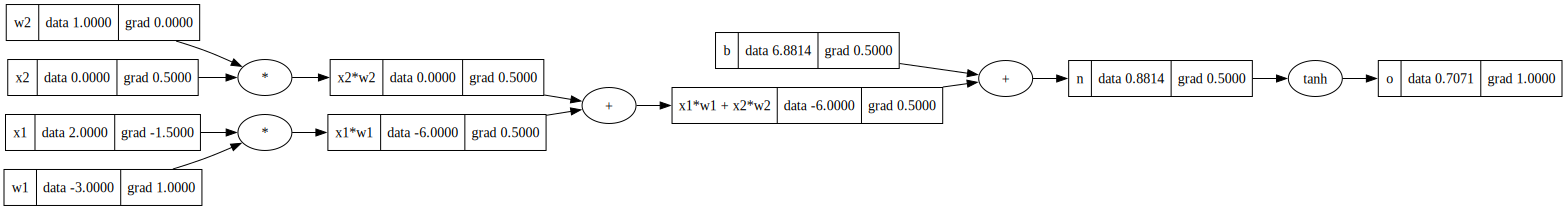

In [184]:
o.backward()
draw_dot(o)

this implementaion has issues if we use a node more than once in an equation

the solution would be to ACCUMULATE THE GRADIENTS rather than setting them 

In [233]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad 
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

Using Pytorch

In [219]:
import torch

# tensors are basically n dimensional Values 
# micrograd is based on Values which are scalars 


x1 = torch.Tensor([2.0]).double()          ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()          ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()         ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()          ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [249]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters
            params.extend(ps)

        return ps

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [Value(2.0), Value(3.0), Value(-1.0)]
n = MLP(3, [4, 4, 1])
n(x)
n(x)

Value(data=0.8688238271102442)

Create a smaple dataset

In [250]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

ypred = [n(x) for x in xs]
ypred

[Value(data=0.8688238271102442),
 Value(data=0.6875154542358684),
 Value(data=0.6590006273879803),
 Value(data=0.8596057428667685)]

In [252]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss


Value(data=5.636909225728596)

We want to minimize the loss function

In [253]:
loss.backward()

In [254]:
loss.grad

1.0

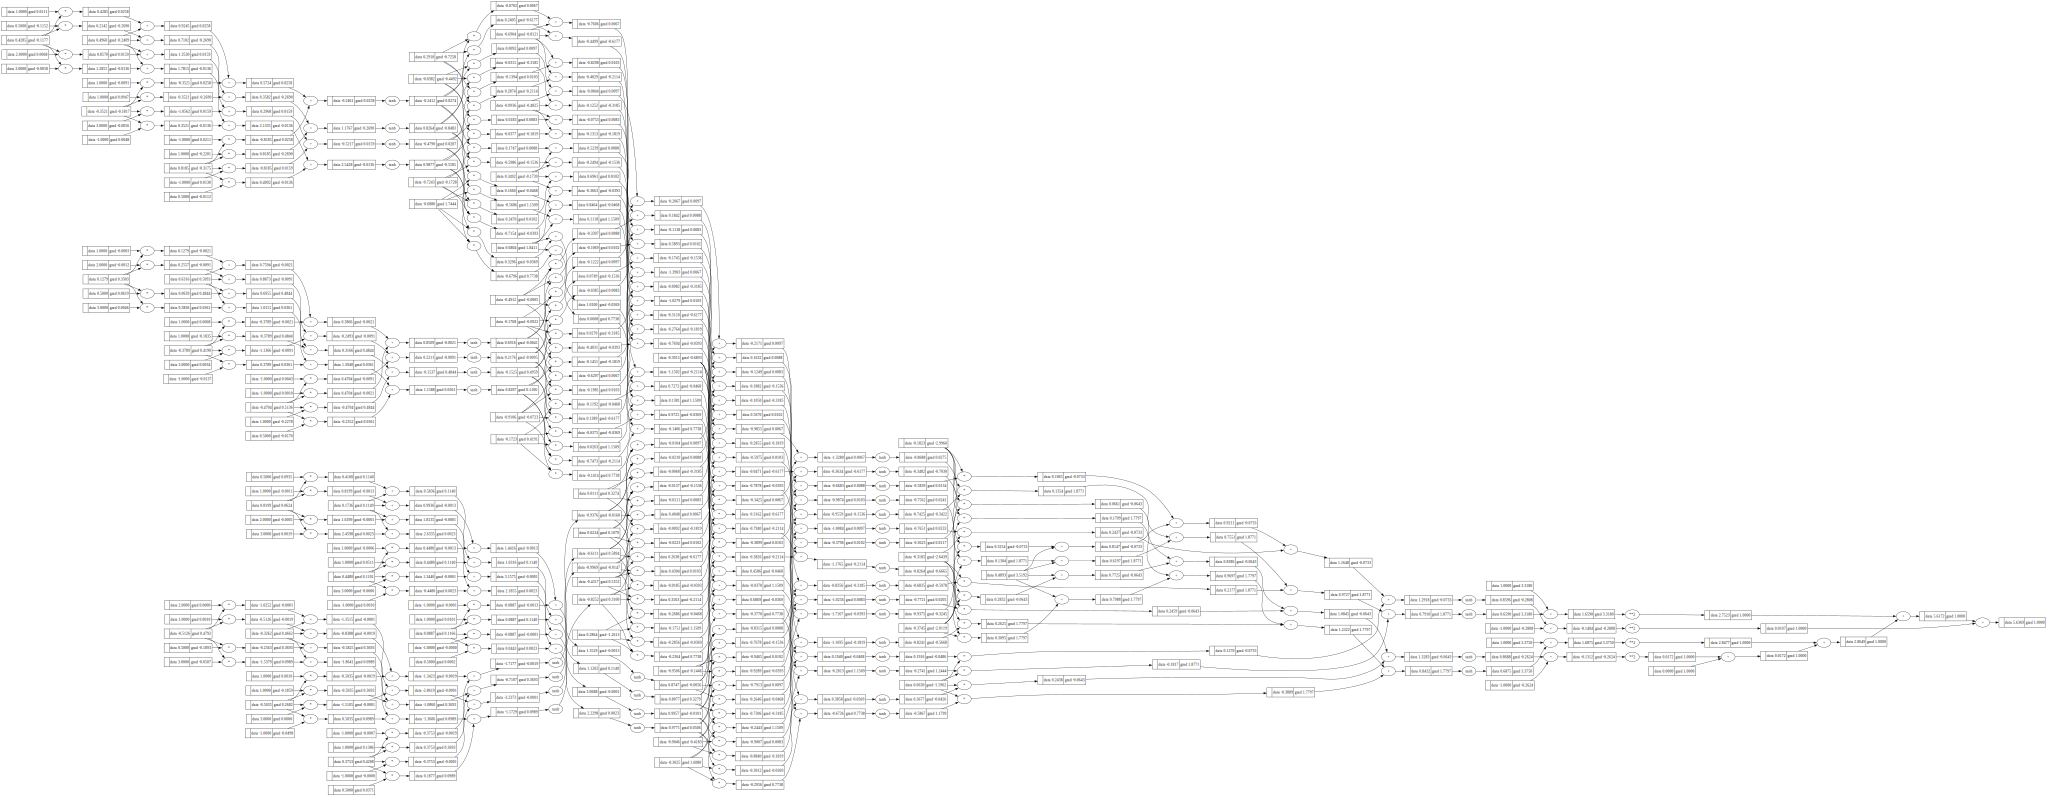

In [255]:
draw_dot(loss)